In [1]:
%reload_ext autoreload
%autoreload 2

import os
import pickle
import logging
import multiprocessing
from pathlib import Path

import pandas as pd
import numpy as np
import jax
import jax.numpy as jnp

import arviz as az
import numpyro

from hbmep.config import Config
from hbmep.model.utils import Site as site

from hbmep_paper.utils import load_intraoperative_data


PLATFORM = "cpu"
jax.config.update("jax_platforms", PLATFORM)
numpyro.set_platform(PLATFORM)

cpu_count = multiprocessing.cpu_count() - 2
numpyro.set_host_device_count(cpu_count)
numpyro.enable_x64()
numpyro.enable_validation()

logger = logging.getLogger(__name__)


In [2]:
import numpyro.distributions as dist
from hbmep.model import BaseModel


class MixedEffects(BaseModel):
    LINK = "mixed_effects"

    def __init__(self, config: Config):
        super(MixedEffects, self).__init__(config=config)
        self.combination_columns =  self.features[::-1] + [self.subject]

    def fn(self, x, a, b, v, L, ell, H):
        return (
            L
            + jnp.where(
                jnp.less(x, a),
                0.,
                -ell + jnp.true_divide(
                    H + ell,
                    jnp.power(
                        1
                        + jnp.multiply(
                            -1
                            + jnp.power(
                                jnp.true_divide(H + ell, ell),
                                v
                            ),
                            jnp.exp(jnp.multiply(-b, x - a))
                        ),
                        jnp.true_divide(1, v)
                    )
                )
            )
        )

    def _model(self, subject, features, intensity, response_obs=None):
        subject, n_subject = subject
        features, n_features = features
        intensity, n_data = intensity

        intensity = intensity.reshape(-1, 1)
        intensity = np.tile(intensity, (1, self.n_response))

        feature0 = features[0].reshape(-1,)
        n_feature0 = n_features[0]

        feature1 = features[1].reshape(-1,)
        n_feature1 = n_features[1]

        with numpyro.plate(site.n_response, self.n_response):
            """ Global Priors """
            b_scale_global_scale = numpyro.sample("b_scale_global_scale", dist.HalfNormal(1))
            v_scale_global_scale = numpyro.sample("v_scale_global_scale", dist.HalfNormal(1))

            L_scale_global_scale = numpyro.sample("L_scale_global_scale", dist.HalfNormal(.5))
            ell_scale_global_scale = numpyro.sample("ell_scale_global_scale", dist.HalfNormal(100))
            H_scale_global_scale = numpyro.sample("H_scale_global_scale", dist.HalfNormal(5))

            g_1_scale_global_scale = numpyro.sample("g_1_scale_global_scale", dist.HalfNormal(100))
            g_2_scale_global_scale = numpyro.sample("g_2_scale_global_scale", dist.HalfNormal(100))

            with numpyro.plate("n_feature1", n_feature1):
                with numpyro.plate("n_feature0", n_feature0):
                    """ Hyper-priors """
                    a_mean = numpyro.sample("a_mean", dist.TruncatedNormal(5, 10, low=0))
                    a_scale = numpyro.sample("a_scale", dist.HalfNormal(10.0))

                    b_scale_raw = numpyro.sample("b_scale_raw", dist.HalfNormal(scale=1))
                    b_scale = numpyro.deterministic("b_scale", jnp.multiply(b_scale_global_scale, b_scale_raw))

                    v_scale_raw = numpyro.sample("v_scale_raw", dist.HalfNormal(scale=1))
                    v_scale = numpyro.deterministic("v_scale", jnp.multiply(v_scale_global_scale, v_scale_raw))

                    L_scale_raw = numpyro.sample("L_scale_raw", dist.HalfNormal(scale=1))
                    L_scale = numpyro.deterministic("L_scale", jnp.multiply(L_scale_global_scale, L_scale_raw))

                    ell_scale_raw = numpyro.sample("ell_scale_raw", dist.HalfNormal(scale=1))
                    ell_scale = numpyro.deterministic("sigma_ell", jnp.multiply(ell_scale_global_scale, ell_scale_raw))

                    H_scale_raw = numpyro.sample("H_scale_raw", dist.HalfNormal(scale=1))
                    H_scale = numpyro.deterministic("H_scale", jnp.multiply(H_scale_global_scale, H_scale_raw))

                    g_1_scale_raw = numpyro.sample("g_1_scale_raw", dist.HalfNormal(scale=1))
                    g_1_scale = numpyro.deterministic("g_1_scale", jnp.multiply(g_1_scale_global_scale, g_1_scale_raw))

                    g_2_scale_raw = numpyro.sample("g_2_scale_raw", dist.HalfNormal(scale=1))
                    g_2_scale = numpyro.deterministic("g_2_scale", jnp.multiply(g_2_scale_global_scale, g_2_scale_raw))

                    with numpyro.plate(site.n_subject, n_subject):
                        """ Priors """
                        a = numpyro.sample("a", dist.TruncatedNormal(a_mean, a_scale, low=0))

                        b_raw = numpyro.sample("b_raw", dist.HalfNormal(scale=1))
                        b = numpyro.deterministic(site.b, jnp.multiply(b_scale, b_raw))

                        v_raw = numpyro.sample("v_raw", dist.HalfNormal(scale=1))
                        v = numpyro.deterministic(site.v, jnp.multiply(v_scale, v_raw))

                        L_raw = numpyro.sample("L_raw", dist.HalfNormal(scale=1))
                        L = numpyro.deterministic(site.L, jnp.multiply(L_scale, L_raw))

                        ell_raw = numpyro.sample("ell_raw", dist.HalfNormal(scale=1))
                        ell = numpyro.deterministic("ell", jnp.multiply(ell_scale, ell_raw))

                        H_raw = numpyro.sample("H_raw", dist.HalfNormal(scale=1))
                        H = numpyro.deterministic(site.H, jnp.multiply(H_scale, H_raw))

                        g_1_raw = numpyro.sample("g_1_raw", dist.HalfCauchy(scale=1))
                        g_1 = numpyro.deterministic(site.g_1, jnp.multiply(g_1_scale, g_1_raw))

                        g_2_raw = numpyro.sample("g_2_raw", dist.HalfCauchy(scale=1))
                        g_2 = numpyro.deterministic(site.g_2, jnp.multiply(g_2_scale, g_2_raw))

        """ Outlier Distribution """
        outlier_prob = numpyro.sample("outlier_prob", dist.Uniform(0., .001))
        outlier_scale = numpyro.sample("outlier_scale", dist.HalfNormal(20))

        with numpyro.plate(site.n_response, self.n_response):
            with numpyro.plate(site.n_data, n_data):
                """ Model """
                mu = numpyro.deterministic(
                    site.mu,
                    self.fn(
                        x=intensity,
                        a=a[subject, feature0, feature1],
                        b=b[subject, feature0, feature1],
                        v=v[subject, feature0, feature1],
                        L=L[subject, feature0, feature1],
                        ell=ell[subject, feature0, feature1],
                        H=H[subject, feature0, feature1]
                    )
                )
                beta = numpyro.deterministic(
                    site.beta,
                    g_1[subject, feature0, feature1] + jnp.true_divide(g_2[subject, feature0, feature1], mu)
                )

                q = numpyro.deterministic("q", outlier_prob * jnp.ones((n_data, self.n_response)))
                bg_scale = numpyro.deterministic("bg_scale", outlier_scale * jnp.ones((n_data, self.n_response)))

                mixing_distribution = dist.Categorical(
                    probs=jnp.stack([1 - q, q], axis=-1)
                )
                component_distributions=[
                    dist.Gamma(concentration=jnp.multiply(mu, beta), rate=beta),
                    dist.HalfNormal(scale=bg_scale)
                ]

                """ Mixture """
                Mixture = dist.MixtureGeneral(
                    mixing_distribution=mixing_distribution,
                    component_distributions=component_distributions
                )

                """ Observation """
                numpyro.sample(
                    site.obs,
                    Mixture,
                    obs=response_obs
                )


In [3]:
toml_path = "/home/vishu/repos/hbmep-paper/configs/paper/intraoperative/config.toml"

config = Config(toml_path=toml_path)
config.BUILD_DIR = os.path.join(config.BUILD_DIR, "subdural-epidural", "adm")
config.FEATURES = ["sc_depth", "sc_laterality"]
# config.RESPONSE = ["Triceps", "APB", "ADM"]
config.RESPONSE = ["ADM"]


config.MCMC_PARAMS["num_warmup"] = 3000
config.MCMC_PARAMS["num_samples"] = 1000

model = MixedEffects(config=config)


2023-11-20 15:52:05,631 - hbmep.config - INFO - Verifying configuration ...
2023-11-20 15:52:05,632 - hbmep.config - INFO - Success!
2023-11-20 15:52:05,654 - hbmep.model.baseline - INFO - Initialized base_model


In [4]:
dir = "/home/vishu/data/"
sc_approach = "posterior"
df = load_intraoperative_data(dir=dir, sc_approach=sc_approach, subdural_epidural_only=True)

df[model.features[0]] = df[model.features[0]].replace({"epidural": "01_epidural", "subdural": "02_subdural"})
df[model.features[1]] = df[model.features[1]].replace({"R": "01_R", "M": "02_M"})

df, encoder_dict = model.load(df=df)

df.shape

2023-11-20 15:52:05,884 - hbmep.utils.utils - INFO - func:load_intraoperative_data took: 0.04 sec
2023-11-20 15:52:05,885 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/paper/intraoperative/subdural-epidural/adm
2023-11-20 15:52:05,886 - hbmep.dataset.core - INFO - Copied config to /home/vishu/repos/hbmep-paper/reports/paper/intraoperative/subdural-epidural/adm
2023-11-20 15:52:05,886 - hbmep.dataset.core - INFO - Processing data ...
2023-11-20 15:52:05,887 - hbmep.utils.utils - INFO - func:load took: 0.00 sec


(188, 229)

In [5]:
mcmc, posterior_samples = model.run_inference(df=df)


2023-11-20 15:52:06,234 - hbmep.model.baseline - INFO - Running inference with base_model ...


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

2023-11-20 15:53:36,638 - hbmep.utils.utils - INFO - func:run_inference took: 1 min and 30.40 sec


In [8]:
_posterior_samples = posterior_samples.copy()
_posterior_samples["outlier_prob"] = _posterior_samples["outlier_prob"] * 0

prediction_df = model.make_prediction_dataset(df=df)
posterior_predictive = model.predict(df=prediction_df, posterior_samples=_posterior_samples)

model.render_recruitment_curves(df=df, encoder_dict=encoder_dict, posterior_samples=_posterior_samples, prediction_df=prediction_df, posterior_predictive=posterior_predictive)
model.render_predictive_check(df=df, encoder_dict=encoder_dict, prediction_df=prediction_df, posterior_predictive=posterior_predictive)


2023-11-20 16:18:47,817 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec


2023-11-20 16:18:49,008 - hbmep.utils.utils - INFO - func:predict took: 1.19 sec
2023-11-20 16:18:49,008 - hbmep.model.baseline - INFO - Rendering recruitment curves ...
2023-11-20 16:18:49,771 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/paper/intraoperative/subdural-epidural/adm/recruitment_curves.pdf
2023-11-20 16:18:49,771 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 0.76 sec
2023-11-20 16:18:49,772 - hbmep.model.baseline - INFO - Rendering posterior predictive checks ...
2023-11-20 16:18:50,478 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/paper/intraoperative/subdural-epidural/adm/posterior_predictive_check.pdf
2023-11-20 16:18:50,479 - hbmep.utils.utils - INFO - func:predictive_checks_renderer took: 0.71 sec
2023-11-20 16:18:50,479 - hbmep.utils.utils - INFO - func:render_predictive_check took: 0.71 sec


Text(0.5, 0.98, 'Triceps')

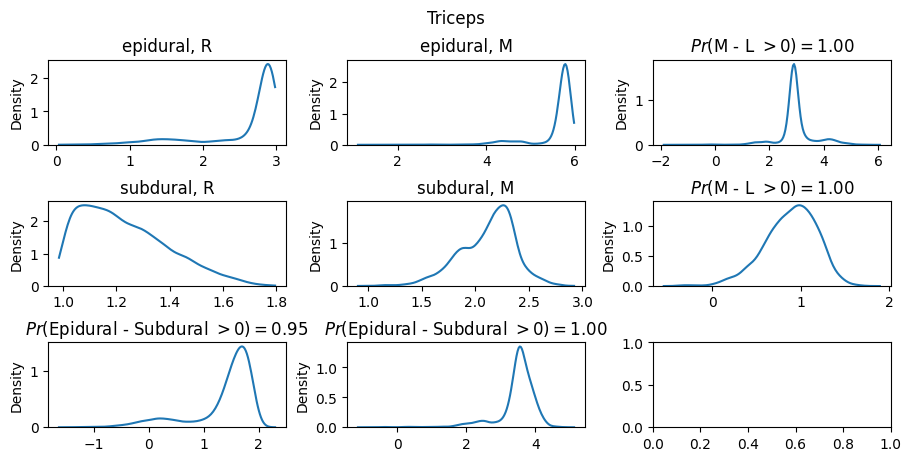

In [10]:
a = posterior_samples[site.a]
a.shape


import matplotlib.pyplot as plt
import seaborn as sns


nrows, ncols = 3, 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3 * ncols, 1.5 * nrows), squeeze=False, constrained_layout=True)

muscle_ind = 0
c = [(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1)]

counter = 0
for _ in range(nrows * ncols):
    i, j = counter // ncols, counter % ncols
    ax = axes[i, j]

    if i in {0, 1} and j < 2:
        sns.kdeplot(a[:, 0, i, j, muscle_ind], ax=ax, cut=0)
        c_inv = []
        c_inv.append(encoder_dict[model.features[0]].inverse_transform([i])[0][3:])
        c_inv.append(encoder_dict[model.features[1]].inverse_transform([j])[0][3:])
        c_inv = ", ".join(c_inv)
        ax.set_title(c_inv)
    counter += 1

    if i in {0, 1} and j == 2:
        samples = a[:, 0, i, 1, muscle_ind] - a[:, 0, i, 0, muscle_ind]
        sns.kdeplot(samples, ax=ax)
        prob = (samples > 0).mean()
        ax.set_title(f"$Pr($M - L $> 0) = ${prob:.2f}")

    if i == 2 and j in {0, 1}:
        ax = axes[i, j]
        samples = a[:, 0, 0, j, muscle_ind] - a[:, 0, 1, j, muscle_ind]
        sns.kdeplot(samples, ax=ax)
        prob = (samples > 0).mean()
        ax.set_title(f"$Pr($Epidural - Subdural $> 0) = ${prob:.2f}")


fig.suptitle("Triceps")


In [10]:
numpyro_data = az.from_numpyro(mcmc)

""" Model evaluation """
logger.info("Evaluating model ...")

score = az.loo(numpyro_data, var_name=site.obs)
logger.info(f"ELPD LOO (Log): {score.elpd_loo:.2f}")

score = az.waic(numpyro_data, var_name=site.obs)
logger.info(f"ELPD WAIC (Log): {score.elpd_waic:.2f}")


2023-11-16 15:28:49,714 - __main__ - INFO - Evaluating model ...
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
2023-11-16 15:28:53,635 - __main__ - INFO - ELPD LOO (Log): 1231.18
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
2023-11-16 15:28:53,697 - __main__ - INFO - ELPD WAIC (Log): 1214.50


In [11]:
import pickle

dest = os.path.join(model.build_dir, "inference.pkl")
with open(dest, "wb") as f:
    pickle.dump((model, mcmc, posterior_samples), f)


In [14]:
os.path.join(model.build_dir, "inference.pkl")

'/home/vishu/repos/hbmep-paper/reports/paper/intraoperative/midline-lateral/inference.pkl'

In [12]:
dest = os.path.join(model.build_dir, "inference.nc")
az.to_netcdf(mcmc, dest)


'/home/vishu/repos/hbmep-paper/reports/paper/intraoperative/midline-lateral/inference.nc'

In [9]:
mcmc.print_summary(prob=.95)



                               mean       std    median      2.5%     97.5%     n_eff     r_hat
           H_raw[0,0,0,0]      1.39      0.62      1.32      0.28      2.56    187.65      1.02
           H_raw[0,0,1,0]      0.78      0.57      0.65      0.02      1.94   2566.62      1.00
           H_raw[0,1,0,0]      2.04      0.60      1.99      0.95      3.22   3258.98      1.00
           H_raw[0,1,1,0]      0.45      0.51      0.26      0.00      1.51   2040.24      1.00
  H_scale_global_scale[0]     11.10      3.05     10.83      5.22     16.92   2888.76      1.00
       H_scale_raw[0,0,0]      1.39      0.60      1.33      0.34      2.57    447.24      1.02
       H_scale_raw[0,1,0]      0.80      0.58      0.67      0.02      1.94   2050.14      1.00
       H_scale_raw[1,0,0]      2.01      0.59      1.96      0.93      3.13   2623.47      1.00
       H_scale_raw[1,1,0]      0.45      0.52      0.26      0.00      1.55   2818.38      1.00
           L_raw[0,0,0,0]      1.16    